In [45]:
from __future__ import print_function, division
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from scipy import stats
import matplotlib.ticker as ticker


In [13]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

## Loading data

In [14]:
data_dir = 'data/'

waveforms = {}

for item in os.listdir(data_dir):
    full_path = os.path.join(data_dir, item)
    waveforms[item.rstrip('.txt')] = pd.read_csv(full_path, sep='\t', index_col=0)

inspecting first of the waveforms

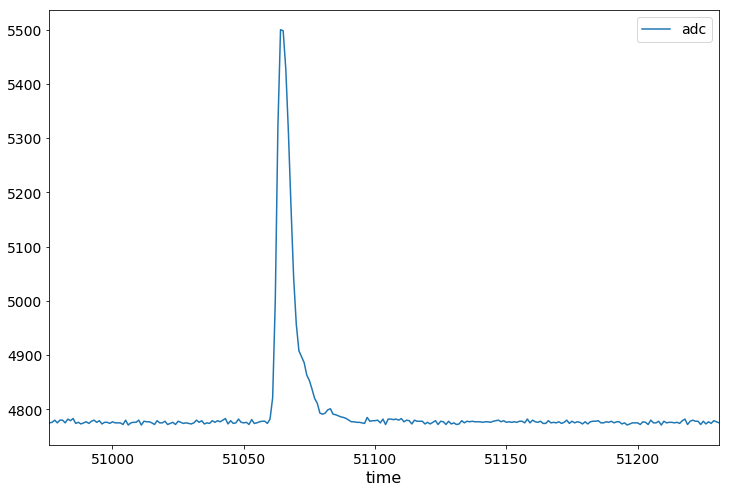

In [15]:
waveforms[list(waveforms)[0]].plot('time', 'adc')

Cutting out the noise from the waveforms

In [31]:
noise = []
for df in waveforms.values():
    noise.append(df['adc'][df['adc'] <= (2. * df['adc'].median()) - df['adc'].min()])

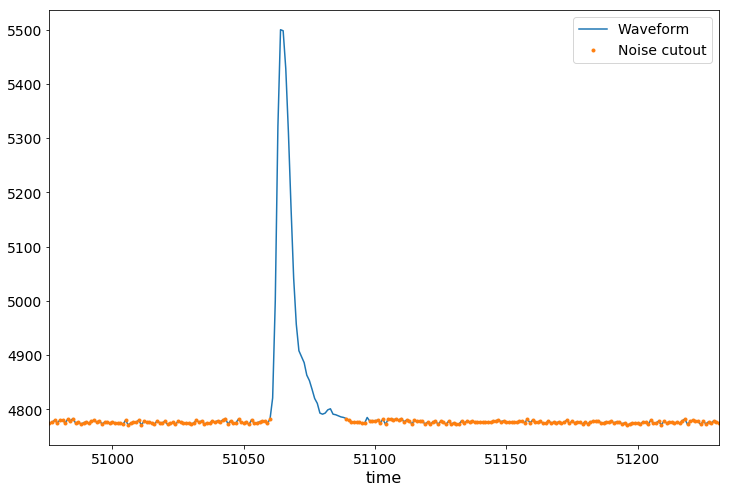

In [32]:
ax = waveforms[list(waveforms)[0]].plot('time', 'adc', label='Waveform')
ax.plot(waveforms[list(waveforms)[0]]['time'][noise[0].index], noise[0], '.', label='Noise cutout')
plt.legend()

Pedestal subtraction

In [33]:
noise = [n - round(n.median()) for n in noise]

Creating one large, concatenated noise sample (maybe not _the_ best idea for FFT)

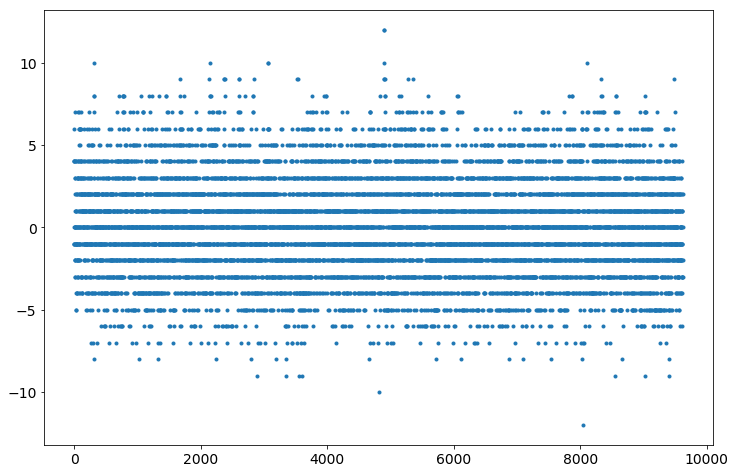

In [34]:
noise = pd.concat(noise, ignore_index=True)

plt.plot(noise, '.')

Text(-9.5, 0.1, 'Noise: 2.93 (ADC units)')

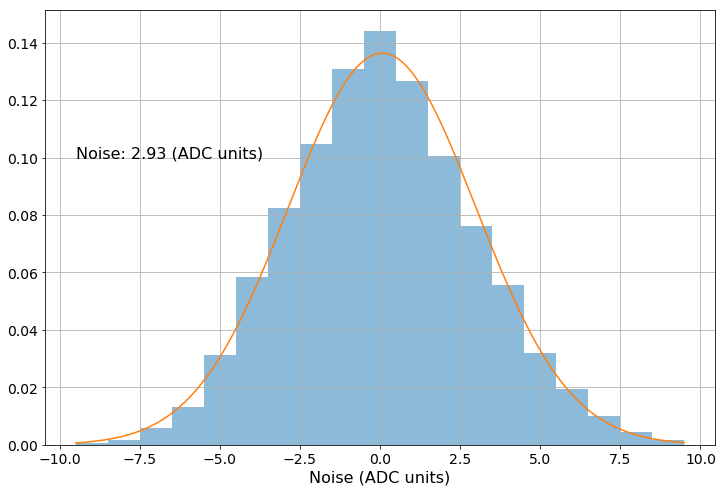

In [35]:
bins = round(noise.mean()) + np.arange(-9.5, 10.5)
x=np.linspace(bins[0], bins[-1], 1000)

noise.hist(bins=bins, density=True, alpha=0.5)

plt.plot(x, stats.norm.pdf(x, loc=noise.mean(), scale=noise.std()))
plt.gca().set_xlabel('Noise (ADC units)')
plt.gca().text(x=bins[0], y = 0.1, s='Noise: %.2f (ADC units)'%noise.std(), fontsize=16)

## FFT (Fast Fourier Transform)

In [54]:
# T = sampling period in ns
T = waveforms[list(waveforms)[0]]['time'].diff()[1] * 10/3
N = len(noise)

dfft = pd.DataFrame()
dfft['amplitude'] = 1 / N * np.abs(np.fft.rfft(noise))
dfft['power'] = dfft['amplitude'] ** 2
dfft['frequency'] = np.fft.rfftfreq(N, d=T) * 1e3

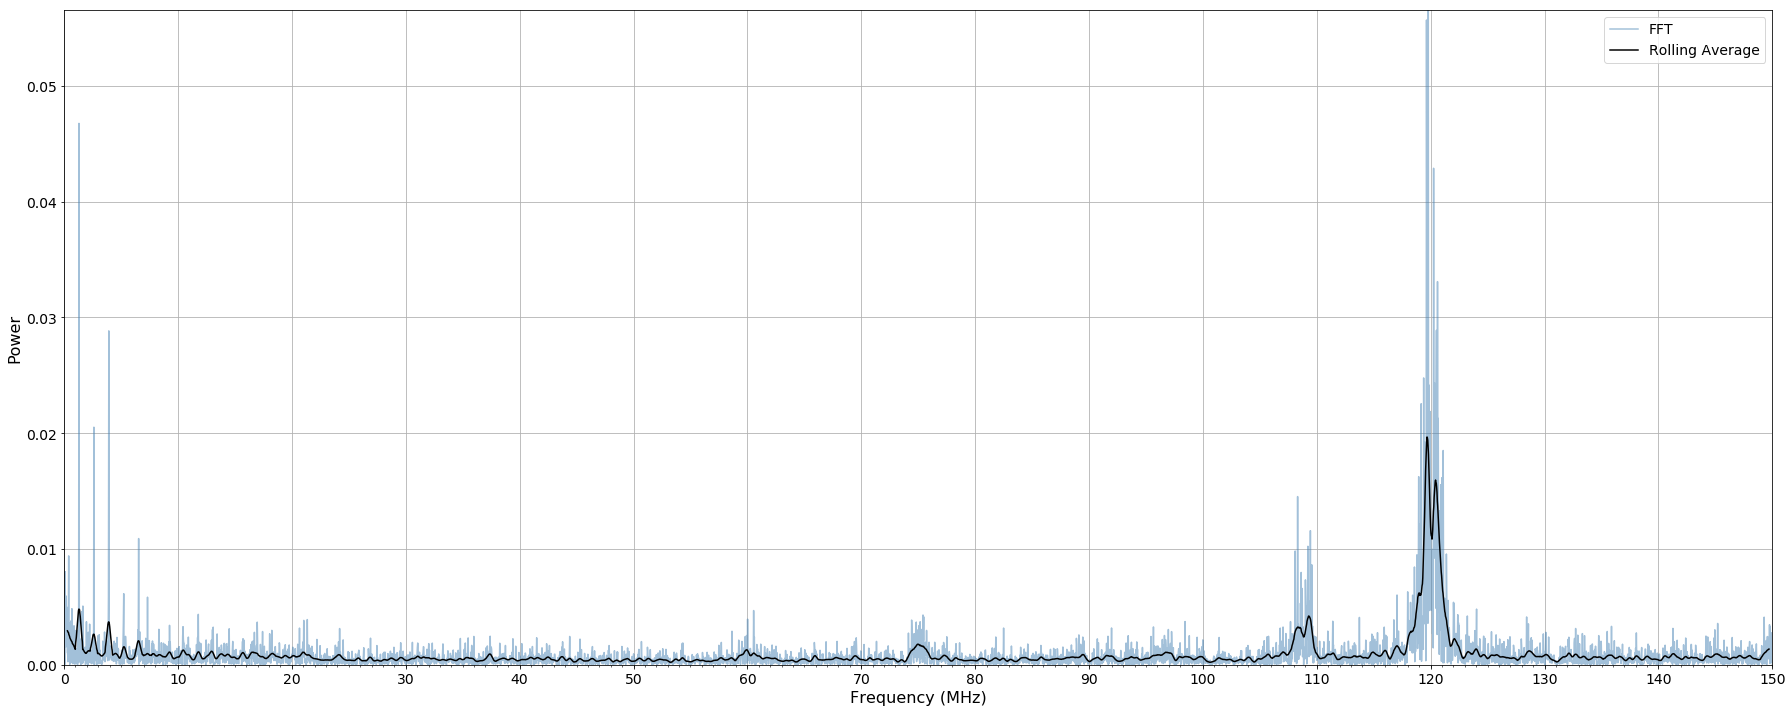

In [57]:
fig, ax = plt.subplots(figsize = (25,10))

dfft.plot('frequency', 'power', ax=ax, label='FFT', c='steelblue', alpha=0.5)
dfft.rolling(window=20, center=True, win_type='gaussian').mean(std=5).plot('frequency', 'power', ax=ax, label='Rolling Average', alpha=1, color='k')


ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Power')
ax.set_ylim([0, dfft['power'].max()])

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid()

plt.tight_layout()

plt.savefig('fft.png')